In [ ]:
import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
from jax import Array
import jax.numpy as jnp

import femsolver
from femsolver.utils import auto_vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors
import sympy as sp


import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

In this notebook, we will demonstrate how to use the `Operator` class for performing various finite element operations.

To keep things simple, we consider a unit square domain with a triangular mesh. 

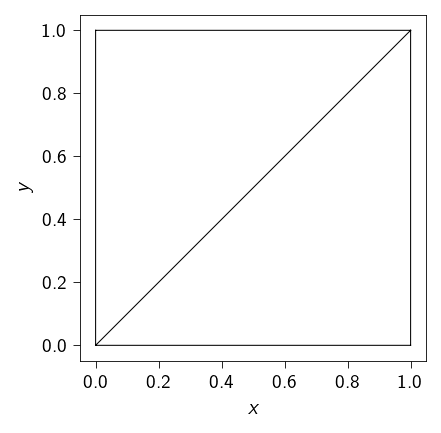

In [104]:
mesh = Mesh.unit_square(1, 1)

plt.style.use(STYLE_PATH)
plt.figure(figsize=(3, 3))
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Now, we define our operator to perform finite element operations in the mesh defined above. The operator is defined for a given mesh and the type of element used in that passed mesh. 


In [105]:
tri = element.Tri3()
op = Operator(mesh, tri)

## Evaluation at quadrature points

We can use the `Operator` to evaluate nodal values at the quadrature points. The function `eval`
takes the nodal values and return the values at the quadrature points.

For example, below we evalutate the coordinate values of the mesh at the quadrature points. This basically means mapping the parameterized quadrature points ($\in [-1, 1]^2$) to the physical space.

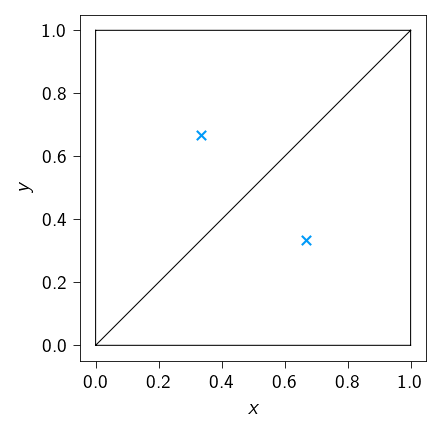

In [106]:
quad_points_in_physical_space = op.eval(mesh.coords).squeeze()

plt.style.use(STYLE_PATH)
plt.figure(figsize=(3, 3))
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.scatter(
    quad_points_in_physical_space[0],
    quad_points_in_physical_space[1],
    c=colors.blue,
    s=20,
    marker="x",
)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.gca().set_aspect("equal")
plt.show()

## Integrating a function over the domain

One basic operation that we require in FEM is to integrate a function over the domain.  For example, integrating the strain energy density over the domain to get the total strain energy.

$$
\Pi_\text{e}(u) = \int_{\Omega} \frac{1}{2} \sigma : \epsilon \, dV
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor evaluated at the quadrature points.

A finite element method way of integrating this over a discretized domain is to approximate the integral as a sum of integrals over the elements in the domain.

$$
\Pi_\text{e}(u) \approx \sum_{e \in \mathcal{E}} \sum_{q \in \mathcal{Q}} \frac{1}{2} \sigma(q) : \epsilon(q) \, J(q) \, w(q)
$$

where $\mathcal{E}$ is the set of all elements in the domain, $\mathcal{Q}$ is the set of all quadrature points in the domain, $J(q)$ is the Jacobian of the transformation from the reference element to the physical element, and $\sigma(q)$ and $\epsilon(q)$ are the stress and strain tensors evaluated at the quadrature point $q$.


To do this, we can use the `Operator` class. The `integrate` method of the `Operator` class takes a function and returns the integral of the function over the domain.  


For example, we want to compute the following integral:

$$
f(x, y) = 10.
$$

The integral of this function over the domain will be equal to 10 times the area of the domain.

$$
\int_{\Omega} f(x, y) \, dV = 10 \times \text{Area of the domain}
$$

To do this, we can define a function that returns 10.0 for any input.



In [107]:
def scalar_function(u: Array,) -> float:
    return 10.0

Now we can use the `Operator` class to integrate the function over the domain. We define a wrapper function that takes 3 arguments:

- `u_quad`: The nodal values at the quadrature points.
- `u_grad`: The gradient of the nodal values at the quadrature points.
- `*_`: Additional values at the quadrature points.

The body of the function then can use the arguments value to compute any functional value at the quadrature points. For this example, we simply call the function `scalar_function` with passing the arguments to it.

We can then decorate the function with `@op.integrate` to tell the `Operator` class that this function is to be integrated over the domain. The `integrate` method of the `Operator` class takes a function, and wraps it in a way that it can be called with the arguments `u_quad`, `u_grad`, and `*_`. So as a user, we do not need to worry about the arguments, and can simply call the function with the nodal values.

In [108]:
@op.integrate
def form_area(u_quad: Array, u_grad: Array, *_) -> float:
    return scalar_function(u_quad)

Now, we can call the decorated `total_area` function. The decorate function now takes the nodal values or some form of nodal values as arguments.

In [109]:
form_area(mesh.coords)

Array(10., dtype=float64)

In the above example, we show how `integrate` method of the `Operator` class can be used to integrate a function over the domain. The function performs various operations under the hood such as:

- Looping over the elements in the mesh.
- Looping over the quadrature points in each element.
- Evaluating the nodal values at the quadrature points _i.e_ `u_quad`.
- Evaluating the gradient of the nodal values at the quadrature points _i.e_ `u_grad`.
- Integrating the function over the domain.


Sometimes, we may want to compute the gradient of a function at the quadrature points. For example, the gradient of the displacement field.

$$
\nabla u = \int_{\Omega} \nabla u \, dV
$$

To do this end, we provide, a wrapper function that takes the nodal values and returns the gradient of the nodal values at the quadrature points.


## Gradients of nodal values

For example, we want to compute the gradient of the coordinate values at the quadrature points.

$$
\nabla \boldsymbol{x} = \begin{bmatrix}
\frac{\partial x}{\partial x} & \frac{\partial x}{\partial y} \\
\frac{\partial y}{\partial x} & \frac{\partial y}{\partial y}
\end{bmatrix}
$$

To do this, we can simply pass our nodal values (in this case, the coordinate values) to the `Operator.grad` function and it will return the gradient of the nodal values at the quadrature points.

In [110]:
op.grad(mesh.coords)

Array([[[[1., 0.],
         [0., 1.]]],


       [[[1., 0.],
         [0., 1.]]]], dtype=float64)

As a sanity check, we can see that the gradient is an identity matrix since the gradient $\partial x / \partial x = 1$ and $\partial y / \partial y = 1$ and all other gradients are zero.

## Passing additional values at the quadrature points

In the previous examples, we have seen how to pass the nodal values to the `Operator` class to perform various operations. However, in some cases, we may want to pass additional values at the quadrature points that we can then use in the function that we are integrating. 

A example of that will be coupled problems where the solution of one field depends on the solution of another field. For example, in a thermo-mechanical problem, the displacement field depends on the temperature field.



For example, we want to compute the following integral:

$$
\int_{\Omega} u(x) \cdot x \, dV
$$

where $u(x)$ is a function of the coordinate values $x$ and $x$ is the x-coordinate values at the quadrature points.


In [111]:
def scalar_function(u: Array, x:Array) -> float:
    return u * x[0] * x[1]


@op.integrate
def form_coupled_area(u_quad: Array, u_grad: Array, x_quad:Array) -> float:
    return scalar_function(u_quad, x_quad)

In [112]:
quad_points_in_physical_space = op.eval(mesh.coords).squeeze()

val = 1.0
u = jnp.ones(mesh.coords.shape[0]) * val

form_coupled_area(u, quad_points_in_physical_space)


Array(0.22222222, dtype=float64)

We can use `sympy` to compute the integral of a function over the domain and match the result with the result from the `Operator` class.

In [113]:
x, y = sp.symbols("x y")

u_expr = val

x_quad_expr = x * y

print(
    f"The integral of {u_expr} * {x_quad_expr} over the domain is {sp.integrate(u_expr * x_quad_expr, (x, 0, 1), (y, 0, 1))}"
)
print(
    f"The result from the `Operator` class is {form_coupled_area(u, quad_points_in_physical_space)}"
)

The integral of 1.0 * x*y over the domain is 0.250000000000000
The result from the `Operator` class is 0.2222222222222222


The error is because the expression that we are trying to integrate is quadratic whereas the interpolation functions in `tri3` are linear. This is classical source of error in FEM called **numerical integration error**. This can be fixed either by using higher order elements or by increasing the discretization density of the mesh.

These strategies of refinement are called:

- **h-refinement**: Refining the mesh by subdividing the elements into smaller elements.
- **p-refinement**: Refining the mesh by increasing the order of the interpolation functions.

We will use the **h-refinement** strategy to fix the error.

